Import packages

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import dython as dy
from os.path import join
import scipy.io.wavfile as wav
import librosa as lbr
from scipy import signal
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.model_selection import KFold, ParameterGrid
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
import noisereduce as nr
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import csv
import warnings
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings('ignore')

Spectrometer function

In [31]:
def spect(arr, fs, n_sub_r,n_sub_c):
    spect_list = []
    for i in range(0,len(arr)):
        # freq, time,  spectrum = signal.spectrogram(x=arr[i], fs=fs[i])
        # spectrum = 10*np.log10(1+spectrum)
        # spectrum = lbr.feature.melspectrogram(arr[i],sr=fs[i])

        spectrum = lbr.feature.mfcc(y=arr[i],sr=16000,n_mfcc=n_sub_r)
        # spect_split1 = np.array_split(spectrum, n_sub_r, axis=0)
        tmp_row = []
        for row in spectrum:
            spect_split2 = np.array_split(row, n_sub_c)
            for block in spect_split2:
                tmp_row.append(block.mean())
        spect_list.append(tmp_row)
        if i%1000 == 0:
            print(i)
    print(np.array(spect_list).shape)
    return spect_list

In [68]:
def data_import(path,par='dev'):
    df_in = pd.read_csv(path)
    df_in = df_in.rename(columns={'Self-reported fluency level ': 'fluency', 'First Language spoken': 'firstLan', 'Current language used for work/school': 'currentLan'})
    df_out = df_in[['fluency','gender','currentLan']]
    X = []
    y = []
    rate_list = []
    i = 0
    counter = 0

    for item in df_in.iterrows():
        filename = item[1]['path']
        data, rate = lbr.load(filename, sr= None)

        '''
        clips = lbr.effects.split(data, top_db=10)
        data_no_silence = []
        for c in clips:
            segment = data[c[0]: c[1]]
            data_no_silence.extend(segment)
        '''
        data_no_silence,index = lbr.effects.trim(data, top_db= 20)
        # data_emp = lbr.effects.preemphasis(np.array(data_no_silence[0]))
        # data_processed = nr.reduce_noise(y=data_emp, sr=rate)

        #data_processed = nr.reduce_noise(y=lbr.effects.preemphasis(lbr.effects.trim(data, top_db= 10)[0]), sr=rate)
        length = data_no_silence.shape[0]/rate
        if par=='dev':
            if length < 3:
                rate_list.append(rate)
                X.append(np.array(data_no_silence))
                label = item[1]['action']+item[1]['object']
                y.append(label)
            else:
                counter+=1
        else:
            rate_list.append(rate)
            X.append(np.array(data_no_silence))
        if i%1000 == 0:
            print(i)
        i+=1

    print("DELETED TRACKS:",counter)

    if par=='dev':
        return df_out,X,y,rate_list
    else:
        return df_out,X,rate_list


Import data

In [69]:
start = time.time()

df_dev,X_dev_list,y_dev_list,rate_dev= data_import('development.csv','dev')
df_ev,X_ev_list,rate_ev = data_import('evaluation.csv','ev')

print(len(X_dev_list))
print(len(X_ev_list))

end = time.time()
print(end-start,'SECONDS')

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
DELETED TRACKS: 54
0
1000
DELETED TRACKS: 0
9800
1455
64.20958185195923 SECONDS


Pre-processing

In [166]:
start = time.time()

n_sub_row = 8
n_sub_col = 25

spectX_dev_list = spect(X_dev_list,rate_dev, n_sub_row, n_sub_col)
print('Spectrometer conversion X_dev: DONE')
spectX_ev_list = spect(X_ev_list, rate_ev, n_sub_row, n_sub_col)
print('Spectrometer conversion X_ev: DONE')

y_dev = pd.DataFrame(np.array(y_dev_list).transpose())
X_dev = pd.DataFrame(spectX_dev_list).fillna(0)
X_ev = pd.DataFrame(spectX_ev_list).fillna(0)
print('Dataframe conversion: DONE')

end = time.time()
print(end-start,'SECONDS')

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
(9800, 200)
Spectrometer conversion X_dev: DONE
0
1000
(1455, 200)
Spectrometer conversion X_ev: DONE
Dataframe conversion: DONE
85.10297870635986 SECONDS


In [167]:

scaler = MinMaxScaler((-1,1))
# scaler = StandardScaler()
scaler.fit(X_dev)
X_dev_n = np.array(scaler.transform(X_dev))
# scaler.fit(X_ev)
X_ev_n = np.array(scaler.transform(X_ev))
print('Normalization: DONE')


Normalization: DONE


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Columns: 175 entries, 0 to 174
dtypes: float32(175)
memory usage: 6.5 MB
None


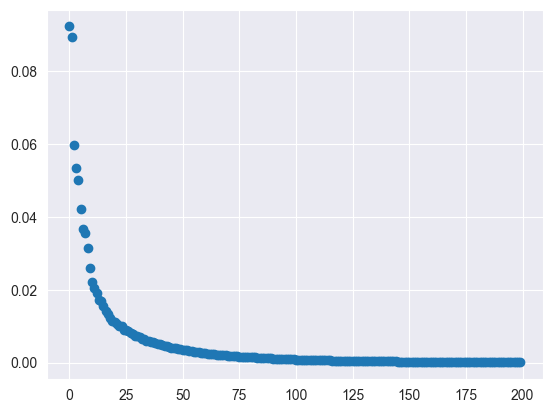

In [190]:
tot_attr = n_sub_row*n_sub_col
max_attr = 180
pca = PCA(n_components=tot_attr)
X_proj = pca.fit_transform(X_dev_n)
plt.plot(pca.explained_variance_ratio_, marker='o', linestyle='')

pca = PCA(n_components=max_attr)
X_dev_proj = pca.fit_transform(X_dev_n)
X_ev_proj = pca.transform(X_ev_n)
X_dev_proj=pd.DataFrame(X_dev_proj)
print(X_dev_proj.info())

In [175]:
X_train_valid, X_test, y_train_valid, y_test = train_test_split(X_dev_proj, y_dev, test_size=0.20,shuffle=True)

Grid-search

In [ ]:
params = {
    "n_estimators": [50, 100, 200, 500],
    "criterion": ["gini", "entropy"]
    }


grid_search = GridSearchCV(RandomForestClassifier(random_state=42), params,cv=5, scoring="accuracy",n_jobs=16)
grid_search.fit(X_train_valid,y_train_valid)
print(grid_search.best_params_, '->', grid_search.best_score_)

In [ ]:
params = {
    "n_estimators": [50, 100, 200, 500],
    "criterion": ["gini", "entropy"]
    }


grid_search = GridSearchCV(ExtraTreesClassifier(random_state=42), params,cv=5, scoring="accuracy",n_jobs=16)
grid_search.fit(X_train_valid,y_train_valid)
print(grid_search.best_params_, '->', grid_search.best_score_)

In [ ]:


params = {
    "n": [5,10,15],
    "weights" : ["uniform", "distance"]
    }


grid_search = GridSearchCV(KNeighborsClassifier(), params,cv=5, scoring="accuracy",n_jobs=16)
grid_search.fit(X_train_valid,y_train_valid)
print(grid_search.best_params_, '->', grid_search.best_score_)

In [102]:
start = time.time()

params = {
    "kernel": ["poly"],
    "degree" : [2,3,4],
    "gamma" : [1, 10],
    "C" : [0.1, 2]
    }


grid_search = GridSearchCV(SVC(random_state=42), params,cv=5, scoring="accuracy",n_jobs=-1)
grid_search.fit(X_train_valid,y_train_valid)
print(grid_search.best_params_, '->', grid_search.best_score_)

end = time.time()
print('{:.2f}'.format(end-start),'SECONDS')

{'C': 0.1, 'degree': 4, 'gamma': 1, 'kernel': 'poly'} -> 0.7800338141237136
80.15 SECONDS


Test

In [206]:
start = time.time()

rf = RandomForestClassifier(n_estimators=700, criterion='entropy',random_state=42,n_jobs=16)
rf.fit(X_train_valid, y_train_valid.values.ravel())
y_prev = rf.predict(X_test)
score1 = f1_score(y_true=y_test, y_pred=y_prev, average='macro')
score2 = accuracy_score(y_true=y_test, y_pred=y_prev)
print(score1," - ",score2)

end = time.time()
print('{:.2f}'.format(end-start),'SECONDS')

0.5311268893600516  -  0.5821428571428572
48.19 SECONDS


In [205]:
start = time.time()

rf = ExtraTreesClassifier(n_estimators=700,criterion='gini',random_state=42,n_jobs=16)
rf.fit(X_train_valid, y_train_valid.values.ravel())
y_prev = rf.predict(X_test)
score1 = f1_score(y_true=y_test, y_pred=y_prev, average='macro')
score2 = accuracy_score(y_true=y_test, y_pred=y_prev)
print(score1," - ",score2)

end = time.time()
print('{:.2f}'.format(end-start),'SECONDS')

0.46414894551584096  -  0.5520408163265306
7.23 SECONDS


In [204]:
start = time.time()

rf = SVC(kernel='poly',gamma=0.1,degree=4,C=5,random_state=42)
rf.fit(X_train_valid, y_train_valid.values.ravel())
y_prev = rf.predict(X_test)
score1 = f1_score(y_true=y_test, y_pred=y_prev, average='macro')
score2 = accuracy_score(y_true=y_test, y_pred=y_prev)
print(score1," - ",score2)

end = time.time()
print('{:.2f}'.format(end-start),'SECONDS')
# kernel='poly',gamma=1,degree=4,C=0.1,random_state=42
# kernel='rbf',gamma=0.1,C=2,random_state=42
# kernel='rbf',gamma=0.1,C=5.2,random_state=42


0.723932150605512  -  0.7285714285714285
16.04 SECONDS


Evaluation

In [201]:
rf = SVC(kernel='rbf',gamma=0.11,C=4.2)
rf.fit(X_dev_proj, y_dev.values.ravel())
y_prev_ev = rf.predict(X_ev_proj)

Generate results

In [200]:
with open('res.csv', mode='w', newline='') as file:
    file_writer = csv.writer(file)
    i = 0
    file_writer.writerow(['Id', 'Predicted'])
    for elem in y_prev_ev:
        file_writer.writerow([i, elem])
        i += 1